# <strong>第三次作品：分類器評比 PART3 - Yale Face 人臉影像</strong>
學號：711233117

姓名：楊廷紳

 <font color=skyblue>作品目標</font>：

此作品利用 Yale 人臉影像資料集，探索並建立有效的分類模型。該模型將根據給定的人臉影像，預測該影像所屬的個人身份。具體而言，我們將實現和比較不同的分類器，例如羅吉斯迴歸、支持向量機和類神經網路等，並根據其在 Yale 人臉影像資料上的表現進行評估和比較。

這個作品的主要目標包括：

1. 搜集和了解 Yale 人臉影像資料集：這將包括瞭解資料集的結構、影像格式、標籤方式等信息，以及確保資料的質量和完整性。

2. 資料預處理和特徵提取：在建立分類模型之前，我們將進行必要的資料預處理工作，包括影像的調整、標準化、降噪等，以確保模型的穩定性和準確性。同時，我們將探索並提取影像中的重要特徵，以供後續模型訓練使用。

3. 建立分類模型：我們將實現並訓練不同的分類器，例如羅吉斯迴歸、支持向量機和人工神經網路等。透過訓練和調參，我們將嘗試建立準確且穩健的模型，以預測人臉影像的身份。

4. 模型評估和比較：最後，我們將使用測試資料集對建立的模型進行評估和比較。我們將通過計算準確率、混淆矩陣等指標來評估模型的性能，並找出最佳的分類器和參數組合。

 <hr>

### **匯入需要使用之套件**

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression , LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import  GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import accuracy_score , classification_report
import warnings
import random
from datetime import datetime

import matplotlib.pyplot as plt
from numpy.linalg import eig
from matplotlib.ticker import PercentFormatter
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore') #處理 warning 結果
# 設置種子碼
random.seed(123)

### **影像資料呈現**

Yale 人臉影像資料集是一個常用於人臉識別和計算機視覺研究的公開資料集之一。這個資料集由耶魯大學的計算機科學系收集和維護，它包含了來自 15 位不同受試者的 165 個灰度人臉影像，每個受試者都有 11 張不同表情和表情變化的影像。

每個人的影像都是在不同的光線條件下拍攝的，並且包含了各種表情，例如微笑、皺眉等。影像的大小為 320x243 像素。

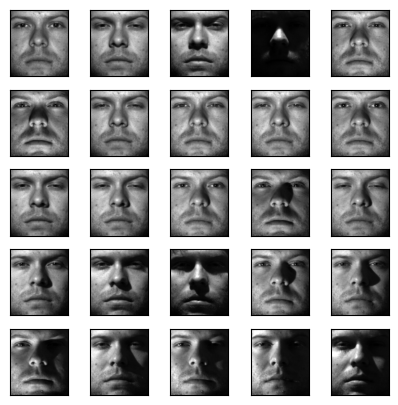

In [2]:
import scipy.io
import os

# 讀取數據
df = scipy.io.loadmat('D:/shallow_ml/pictures/allFaces.mat')

def show_montage(X, n, m, h, w):
    '''
    X: 影像資料矩陣，每行代表一張影像
    n,m: 每張影像的大小 nxm
    h,w: 建立一個蒙太奇圖陣，大小 figsize=(w,h)
    '''
    fig, axes = plt.subplots(h, w, figsize=(w, h))
    if X.shape[1] < w * h: 
        X = np.c_[X, np.zeros((X.shape[0], w*h - X.shape[1]))]
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[:,i].reshape(m, n).T, cmap='gray') #.T
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

X = df['faces']
n, m = 192, 168 #將大小調成 64*64
#初步觀察影像資料
show_montage(X, n , m , 5, 5) #5*5

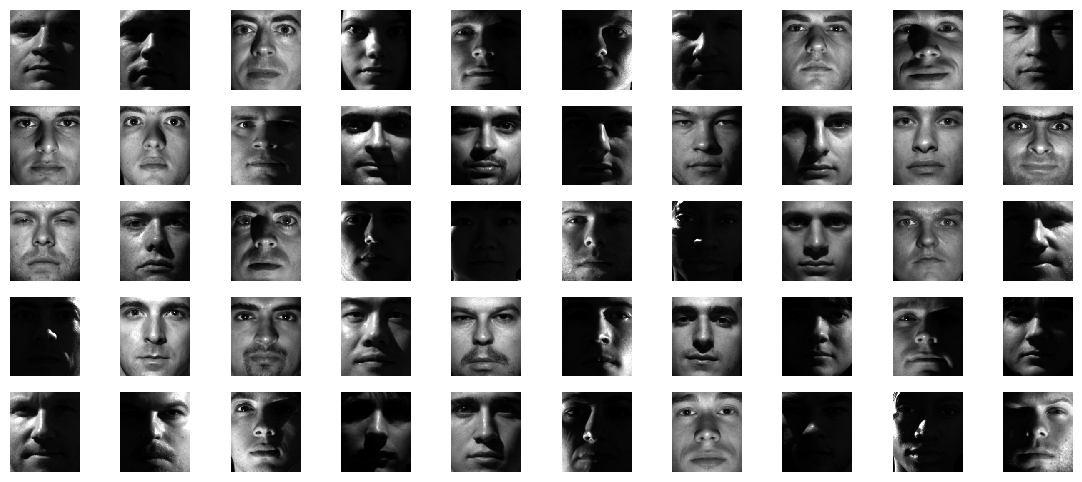

In [3]:
def plot_random_faces(pixels, N=50 ,n=192,m=168):
    fig, axes = plt.subplots(5, 10, figsize=(14, 6))
    sample_indices = random.sample(range(len(pixels)), N)
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.array(pixels)[sample_indices[i]].reshape(m, n).T, cmap='gray', interpolation='nearest')
        ax.axis('off')
    plt.show()

X = df['faces'].T
plot_random_faces(X)

### **提取人臉數據**

In [4]:
# 數據轉換：將圖像數據轉為DataFrame，每列代表一個圖像
X = pd.DataFrame(df['faces'].T)  # 轉置以匹配行列要求
# 提取每個人臉的計數並將其扁平化
face_counts = df['nfaces'].flatten()
# 從數據中提取圖像的維度和參與人數
img_height = int(df['n'])
img_width = int(df['m'])
total_persons = int(df['person'])
print(face_counts ,'\n' , img_height, img_width,'\n', total_persons)

[64 62 64 64 62 64 64 64 64 64 60 59 60 63 62 63 63 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64] 
 192 168 
 38


可以發現此筆資料的影像數據有 <font color=yellow>38</font> 個不同的人臉，每張人臉都有將近 <font color=yellow>60</font> 張不同的照片。每張像素為 <font color=yellow>192*168</font> 。依照這些資訊去賦予資料標籤。

In [5]:
# 定義標籤：根據每個人臉的影像張數去重複生成標籤
face_counts = df['nfaces'][0]  # 提取每個人臉張數
y = np.repeat(np.arange(len(face_counts)), face_counts)

### **原始資料進行切割並標準化資料**

#### <font color=yellow> 標準化的用意 </font>
對於某些機器學習模型，如邏輯斯回歸和支持向量機（SVM）等，影像資料的標準化通常是有助於模型收斂和性能的。標準化可以使得每個特徵的平均值為0，標準差為1，這樣可以幫助模型更快地收斂到最優解。

另一方面，在某些深度學習模型中，如卷積神經網路（CNN），影像資料通常不需要嚴格的標準化，因為這些模型可以自行學習到特徵的分佈和變化。

因此，是否對影像資料進行標準化取決於所使用的模型以及具體的應用場景。在實際應用中，可以試驗不同的方法，觀察模型的效果，並根據需要進行調整。

In [6]:
# Split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Standardize data
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.fit_transform(X_test)

<hr>

## <font color=orange>資料降維 </font> 

奇異值分解（SVD）在機器學習中有許多應用，特別是在降維和特徵提取方面。以下是SVD運用在機器學習模型中的一些好處：

- <font color=yellow>降低維度</font> : SVD可以將高維度的資料轉換為低維度的表示，從而減少資料的複雜度和計算成本。這對於處理大規模資料和高維度特徵的應用非常有用，可以提高模型的效率和性能。

- <font color=yellow>去除噪聲</font> : SVD可以幫助我們去除資料中的噪聲和不必要的變動，從而提高模型的魯棒性和泛化能力。通過保留最重要的特徵，可以減少過擬合的風險，使模型更加準確地捕捉到資料的本質。

- <font color=yellow>特徵提取</font> : SVD可以幫助我們提取資料中的主要特徵，從而更好地理解資料的結構和模式。這些特徵可以用於後續的模型訓練和預測，從而提高模型的性能和準確度。

- <font color=yellow>可解釋性</font> : SVD轉換後的低維表示通常更容易解釋和理解，因為它們包含了原始資料的主要變異性。這使得我們能夠更好地理解模型的預測結果和特徵之間的關係，從而做出更明智的決策。

總歸來說，SVD在機器學習模型中的應用可以幫助我們處理高維度和大規模的資料，提高模型的效率、準確性和可解釋性。它是一個強大的工具，可以應用於各種機器學習任務中，包括分類、迴歸、聚類等。

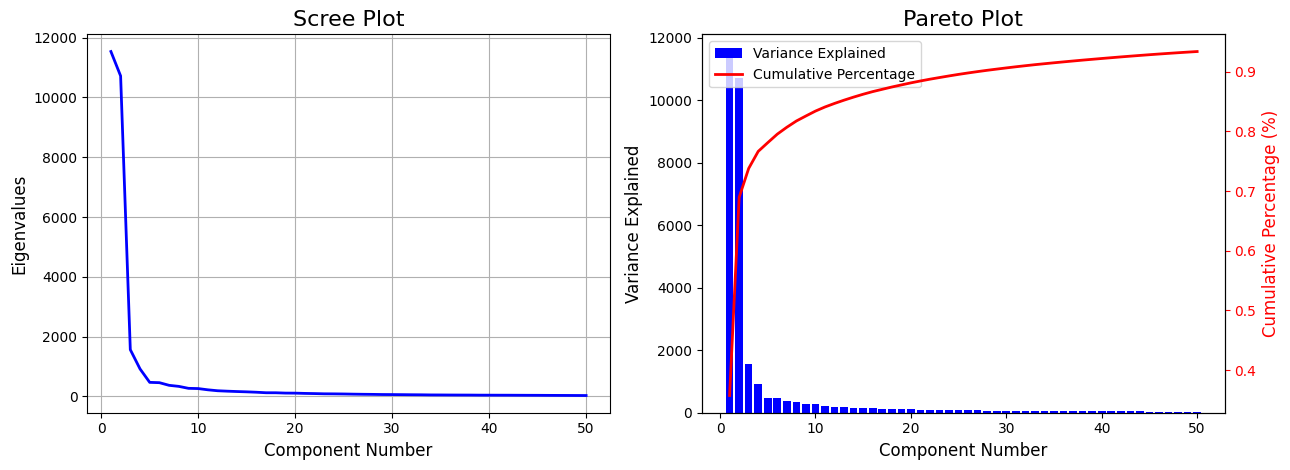

In [7]:
# Assuming X_train_ is your training data
ratings = np.array(X_train_)
# Standardize the ratings
scaler = StandardScaler()
ratings_ = scaler.fit_transform(ratings)

# Apply PCA to the training data and retain the first 50 principal components
pca = PCA(n_components=50).fit(ratings_)

# Set up the canvas and subplot structure
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 4.8))

# Draw Scree Plot
components = np.arange(1, 1 + len(pca.explained_variance_))
ax1.plot(components, pca.explained_variance_, lw=2 , color='blue')
ax1.set_xlabel('Component Number', fontsize=12)
ax1.set_ylabel('Eigenvalues', fontsize=12)
ax1.grid(True)
ax1.set_title('Scree Plot', fontsize=16)

# Draw Pareto Plot
ax2.bar(components, pca.explained_variance_, label='Variance Explained' , color='blue')
ax2_twin = ax2.twinx()
ax2_twin.plot(components, pca.explained_variance_ratio_.cumsum(), color='red', lw=2, label='Cumulative Percentage')
ax2_twin.tick_params(axis='y', colors='red')
ax2_twin.set_ylabel('Cumulative Percentage (%)', fontsize=12, color="red")
ax2.set_xlabel('Component Number', fontsize=12)
ax2.set_ylabel('Variance Explained', fontsize=12)
ax2.set_title('Pareto Plot', fontsize=16)

# Add legend
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax2.legend(lines, labels, loc='upper left')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


選擇<font color=yellow>約 45 </font>個主成分能解釋的變異量不再提升，且能解釋超過<font color=yellow>九成</font>的變異。所以選擇到 <font color=yellow>45</font> 個主成分個數。

In [8]:
from sklearn.decomposition import TruncatedSVD
# 建立TruncatedSVD模型並擬合訓練資料
svd = TruncatedSVD(n_components=45).fit(X_train_) #4096~30
# 將訓練和測試資料進行降維
Z_train = svd.transform(X_train_)
Z_test = svd.transform(X_test_)

<hr>

## <font color=orange> 降維資料模型測試 </font> 

人臉影像資料通常具有巨大的維度，因為每個影像都是由大量的像素組成的。例如，一個常見的320x243像素的人臉影像就有77,760個特徵。這樣高維度的資料集對於機器學習算法來說可能會面臨一些挑戰：

1. 計算複雜度高: 高維度的資料集需要更多的計算資源和時間來訓練模型。尤其是對於一些複雜的機器學習算法，如支持向量機（SVM）或神經網絡，這種計算複雜度更加明顯。

2. 維度災難: 在高維度空間中，資料點之間的距離變得更加稀疏，這會導致所謂的“維度災難”。在這種情況下，機器學習算法可能會出現過度擬合的問題，導致模型在新資料上的表現不佳。

 ### <font color=orange> SVD 資料 - 羅吉斯模型</font> 

In [9]:
opts = dict(tol = 1e-6, max_iter = int(1e5), verbose=False)
#solver = 'lbfgs' # ’lbfgs’ is the default
#solver = 'liblinear'
solver = 'newton-cg'
clf_pca = LogisticRegression(solver = solver, **opts)
clf_pca.fit(Z_train, y_train)
y_pred = clf_pca.predict(Z_test)

# 測 試 資 料 之 準 確 率 回 報
print(f'Test set classification accuracy of Logistic Regression:{accuracy_score(y_test, y_pred):.2%}\n')
print(f'Test set classification accuracy of Logistic Regression:{clf_pca.score(Z_test, y_test):.2%}\n')
print('---------------------------------------------------------------------------')
print(classification_report(y_test, y_pred))

Test set classification accuracy of Logistic Regression:91.84%

Test set classification accuracy of Logistic Regression:91.84%

---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        15
           1       0.81      0.81      0.81        21
           2       0.80      1.00      0.89        16
           3       0.89      1.00      0.94        25
           4       1.00      0.88      0.94        26
           5       1.00      0.88      0.93        16
           6       1.00      0.80      0.89        25
           7       0.83      1.00      0.91        20
           8       1.00      0.96      0.98        24
           9       0.89      0.80      0.84        20
          10       0.94      0.84      0.89        19
          11       1.00      1.00      1.00        11
          12       0.94      0.94      0.94        18
          13       1.00      1.00      

 ### <font color=orange> SVD 資料 - SVM 模型</font> 

In [10]:
opts = dict(C = 10, tol = 1e-6, max_iter = int(1e6))

svm_clf_original = SVC(kernel = 'rbf', **opts)
svm_clf_original.fit(Z_train, y_train)
y_pred = svm_clf_original.predict(Z_test)

print(f'Test set classification accuracy of Support Vector Machine:{accuracy_score(y_test, y_pred):.2%}\n')
print(f'Test set classification accuracy of Support Vector Machine:{svm_clf_original.score(Z_test, y_test):.2%}\n')
print('---------------------------------------------------------------------------')
print(classification_report(y_test, y_pred))

Test set classification accuracy of Support Vector Machine:88.93%

Test set classification accuracy of Support Vector Machine:88.93%

---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        15
           1       1.00      0.81      0.89        21
           2       0.87      0.81      0.84        16
           3       1.00      0.96      0.98        25
           4       1.00      0.88      0.94        26
           5       0.84      1.00      0.91        16
           6       1.00      0.80      0.89        25
           7       0.94      0.85      0.89        20
           8       1.00      0.96      0.98        24
           9       0.94      0.85      0.89        20
          10       1.00      0.79      0.88        19
          11       1.00      1.00      1.00        11
          12       1.00      0.83      0.91        18
          13       1.00      0.94

 ### <font color=orange> SVD 資料 - ANN模型</font> 

In [11]:
hidden_layers = (20)
activation = 'relu'
opts = dict(hidden_layer_sizes = hidden_layers, verbose = False, activation = activation, tol = 1e-6, max_iter = int(1e6))
# solver = ’sgd’ # not efficient, need more tuning # solver = ’lbfgs’ # not suitable here
solver = 'lbfgs' # default solver
Ann_clf_original = MLPClassifier(solver = solver, random_state = 8, **opts)
Ann_clf_original.fit(Z_train, y_train)
y_pred= Ann_clf_original.predict(Z_test)

print(f'Test set classification accuracy of Neural Network:{accuracy_score(y_test, y_pred):.2%}\n')
print(f'Test set classification accuracy of Neural Network:{Ann_clf_original.score(Z_test, y_test):.2%}\n')
print('---------------------------------------------------------------------------')
print(classification_report(y_test, y_pred))

Test set classification accuracy of Neural Network:88.52%

Test set classification accuracy of Neural Network:88.52%

---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.89      0.81      0.85        21
           2       0.88      0.94      0.91        16
           3       0.92      0.96      0.94        25
           4       0.93      0.96      0.94        26
           5       0.93      0.88      0.90        16
           6       0.90      0.76      0.83        25
           7       0.83      1.00      0.91        20
           8       1.00      0.88      0.93        24
           9       0.84      0.80      0.82        20
          10       0.95      1.00      0.97        19
          11       0.85      1.00      0.92        11
          12       0.94      0.94      0.94        18
          13       0.89      0.94      0.92      

<hr>

## <font color=orange> 參數優化之模型訓練 </font> 

使用 `Pipeline` 可以將多個資料處理步驟串連起來，以便更容易地對整個流程進行訓練、調整參數和評估模型。在 Pipeline 中，各個步驟依次應用，並且每個步驟的輸出將作為下一個步驟的輸入。這對於避免資料洩露和簡化程式碼結構都非常有用。

In [12]:
from sklearn.pipeline import Pipeline

# 定義 svd Pipeline
pipe_svd_lr = Pipeline([
    ('lr', LogisticRegression())
])

pipe_svd_svm = Pipeline([
    ('svm', SVC())
])

pipe_svd_ann = Pipeline([
    ('ann', MLPClassifier())
])

In [13]:
# 定義svd參數範圍 #物件名稱要打對 (_ _)
params_svd_lr = {
    'lr__solver': ['newton-cg', 'lbfgs', 'saga']
}

params_svd_svm = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': [ 'poly', 'rbf', 'sigmoid']
}

params_svd_ann = {
    'ann__hidden_layer_sizes': [(20,), (30,), (30, 30), (20,30,10)],
    'ann__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'ann__solver': ['lbfgs', 'adam', 'sgd']
}

In [14]:
# 定義 GridSearchCV
grid_svd_lr = GridSearchCV(pipe_svd_lr, params_svd_lr, cv=4)
grid_svd_svm = GridSearchCV(pipe_svd_svm, params_svd_svm, cv=4)
grid_svd_ann = GridSearchCV(pipe_svd_ann, params_svd_ann, cv=4)

# 進行交叉驗證調整參數並找到最好的模型
grid_svd_lr.fit(Z_train, y_train)
grid_svd_svm.fit(Z_train, y_train)
grid_svd_ann.fit(Z_train, y_train)

GridSearchCV(cv=4, estimator=Pipeline(steps=[('ann', MLPClassifier())]),
             param_grid={'ann__activation': ['identity', 'logistic', 'tanh',
                                             'relu'],
                         'ann__hidden_layer_sizes': [(20,), (30,), (30, 30),
                                                     (20, 30, 10)],
                         'ann__solver': ['lbfgs', 'adam', 'sgd']})

上述程式碼定義了三個使用了奇異值分解（SVD）的Pipeline，分別用於羅吉斯迴歸（Logistic Regression）、支持向量機（Support Vector Machine，SVM）和人工神經網路（Artificial Neural Network，ANN）模型。接著使用 `GridSearchCV` 來進行交叉驗證調整參數，找到最好的模型。

這些Pipeline和GridSearchCV的結構相似，都是根據指定的參數範圍對模型進行訓練和調參。<font color=skyblue>這裡有幾個值得注意的地方</font>：

1. <font color=skyblue>參數範圍設置</font>: 定義了不同模型的參數範圍，包括SVD的降維維度以及各個模型的相關參數（如羅吉斯迴歸的solver、支持向量機的C和kernel、人工神經網路的hidden_layer_sizes、activation和solver等）。

2. <font color=skyblue>交叉驗證</font>: 使用GridSearchCV對每個模型進行交叉驗證調參，這有助於選擇最佳的參數組合，提高模型的泛化能力。

3. <font color=skyblue>模型訓練</font>: 在每次交叉驗證中，會將訓練集分為訓練和驗證集，使用訓練集對模型進行訓練，然後在驗證集上評估模型的性能。這樣可以防止模型對訓練集過度擬合，提高模型的泛化能力。

最終，`GridSearchCV` 會選擇具有最佳性能的模型和參數組合，從而得到最優的結果。透過這樣的流程，讓不同模型進行全面的比較和評估，找到最適合解決問題的模型。

In [15]:
# 計算最好的參數和交叉驗證得分
print('Logistic Regression with SVD:', grid_svd_lr.best_params_, grid_svd_lr.best_score_)
print('SVM with SVD:', grid_svd_svm.best_params_, grid_svd_svm.best_score_)
print('Neural Network with SVD:', grid_svd_ann.best_params_, grid_svd_ann.best_score_)

Logistic Regression with SVD: {'lr__solver': 'newton-cg'} 0.9010030282221296
SVM with SVD: {'svm__C': 10, 'svm__kernel': 'rbf'} 0.8583321137891051
Neural Network with SVD: {'ann__activation': 'identity', 'ann__hidden_layer_sizes': (20,), 'ann__solver': 'sgd'} 0.8844055003320913


降維資料的訓練能夠達到八成的準確率是一個顯著的結果，表明降維技術在人臉識別或其他相關任務中的應用是有效的。這意味著我們可以通過捕捉資料中的主要特徵，將高維度的資料轉換為低維度表示形式，同時保留了足夠的資訊以實現高準確率的預測。

<hr>

## <font color=orange> 預測模型 </font> 

將測試資料集輸入到模型中，並使用模型學習到的權重和參數進行預測。我們可以評估模型的預測結果，比較預測值與實際值之間的差異，並使用相應的評估指標（如準確度、精確度、召回率等）來評估模型的性能。在進行預測之前，需要確保測試資料集與模型訓練和驗證資料集具有相同的資料預處理步驟，以確保模型能夠對測試資料集進行準確的預測。使用參數優化後的模型進行預測是一個關鍵步驟，可以幫助我們評估模型在真實情況下的表現，並做出相應的調整和改進。

In [18]:
y_pred_svd_lr = grid_svd_lr.predict(Z_test)  #會自己搜尋最佳參數
print(classification_report(y_test, y_pred_svd_lr))

print('---------------------------------------------------------------------------')

y_pred_svd_svm = grid_svd_svm.predict(Z_test)
print(classification_report(y_test, y_pred_svd_svm))

print('---------------------------------------------------------------------------')

y_pred_svd_ann = grid_svd_ann.predict(Z_test)
print(classification_report(y_test, y_pred_svd_ann))


              precision    recall  f1-score   support

           0       0.82      0.93      0.87        15
           1       0.81      0.81      0.81        21
           2       0.80      1.00      0.89        16
           3       0.89      1.00      0.94        25
           4       1.00      0.88      0.94        26
           5       1.00      0.81      0.90        16
           6       1.00      0.80      0.89        25
           7       0.83      1.00      0.91        20
           8       1.00      0.96      0.98        24
           9       0.84      0.80      0.82        20
          10       0.94      0.84      0.89        19
          11       1.00      1.00      1.00        11
          12       0.94      0.94      0.94        18
          13       1.00      1.00      1.00        18
          14       0.86      1.00      0.93        19
          15       0.87      0.93      0.90        14
          16       0.85      1.00      0.92        17
          17       1.00    

降維後的資料在預測模型中表現出了良好的效果。通過降低資料的維度，我們可以更有效地捕捉資料中的重要特徵，同時減少了模型訓練和預測的計算負擔。這有助於減少過擬合的風險，提高模型的泛化能力，從而在未見過的資料上表現更好。此外，降維還可以提高模型的解釋性，使得模型的預測結果更易於理解和解釋。總的來說，降維資料在預測模型中的應用為我們提供了一個有效的工具，以更準確地捕捉資料的結構和模式，並生成更可靠的預測結果。

<hr> 

## <font color=orange> 結語 </font> 

在分類模型上，Yale人臉影像資料集展現出了相當良好的效果。這個資料集的多樣性和規模為模型訓練提供了充足的資料，使得模型能夠更好地學習人臉的特徵和模式。透過適當的資料預處理和特徵工程，搭配適用的分類算法和模型調參，Yale人臉資料集可以實現高精度的人臉分類。此外，該資料集也可作為評估新算法和模型性能的標準基準，促進相關研究的發展和進步。總結來說，Yale人臉影像資料集為人臉分類模型的訓練和評估提供了一個寶貴的資源。